In [1]:
import uproot as up
import awkward as ak
import pandas as pd
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from pathlib import Path

import mplhep as hep
hep.style.use('ROOT')

In [2]:
class Event:
    def __init__(self, time_since_last_trigger_us, timestamp_us, nhits, 
                 digit_pmt_id, digit_charge_pc, total_digit_charge_pc, digit_time_ns, digit_ncrossings, 
                 log_pmt_id, log_charge_pc, total_log_charge_pc, log_time_ns,
                 gaussian_pmt_id, gaussian_charge_pc, total_gaussian_charge_pc, gaussian_time_ns,
                 mcx, mcy, mcz): 
        # Global event data
        self.time_since_last_trigger_us = time_since_last_trigger_us
        self.timestamp_us = timestamp_us
        self.nhits = nhits
        self.total_digit_charge_pc = total_digit_charge_pc # ***BROKEN*** 
        self.total_log_charge_pc = total_log_charge_pc # ***BROKEN*** 
        self.total_gaussian_charge_pc = total_gaussian_charge_pc # USE THIS ONE
        self.trigger_type = None # 0=prompt 1=follower
        self.time_since_last_prompt_trigger_us = None

        # Arrays with PMT information 
        self.digit_pmt_id = digit_pmt_id # id of every pmt hit 
        self.digit_ncrossings = digit_ncrossings # number of crossings for every pmt hit 
        self.digit_time_ns = digit_time_ns # time of first crossing for every pmt hit
        self.digit_charge_pc = digit_charge_pc # ***BROKEN*** total charge for every pmt hit
        self.log_pmt_id = log_pmt_id 
        self.log_charge_pc = log_charge_pc # ***BROKEN*** total charge for every pmt hit 
        self.log_time_ns = log_time_ns 
        self.gaussian_pmt_id = gaussian_pmt_id
        self.gaussian_charge_pc = gaussian_charge_pc
        self.gaussian_time_ns = gaussian_time_ns
        self.mcx=mcx
        self.mcy=mcy
        self.mcz=mcz



    def print(self):
        print("---------------------------------------")
        print(f"                     Timestamp : {self.timestamp_us:.3f} us")
        print(f"       Time since last trigger : {self.time_since_last_trigger_us:.3f} us ")
        print(f"                  Trigger Type : {self.trigger_type}")
        print(f"Time since last prompt trigger : {self.time_since_last_prompt_trigger_us}")
        print(f"                         NHits : {self.nhits}")


class Run:
    def __init__(self,number):
        # Run data
        self.number = number 
        self.files = []

        # Meta data (non event dependent)
        self.pmt_type = None
        self.pmt_id = None
        self.pmt_ch = None
        self.pmt_is_online = None 
        self.pmt_cable_offset = None

        # Event data
        self.events = []

    # Load data for the run
    def load_files(self, path):
        path = Path(path)
        self.files = path

    # Can open any one of the run files to get this
    def load_meta_data(self):
        f=up.open(self.files)
        print(f['output'].keys())
        print(f['meta'].keys())

        self.pmt_type = f['meta']['pmtType'].array(library='np')[0]
        self.pmt_id = f['meta']['pmtId'].array(library='np')[0]
        self.pmt_ch = f['meta']['pmtChannel'].array(library='np')[0]
        #self.pmt_is_online = f['meta']['pmtIsOnline'].array(library='np')[0]
        self.pmt_is_online = [True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,True,True,False,False,True,True,False,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,True,False,True,True,True,False,True,True,True,True,True,True,True,False,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,False,False,True,True,True,True,False,True,True,False,False,False,True,True,False,False,False,True,False,True,True,False,False,True,True,True,True,True,False,True] 
        self.pmt_cable_offset = f['meta']['pmtCableOffset'].array(library='np')[0]
        self.pmtx = f['meta']['pmtX'].array(library='np')[0]
        self.pmty = f['meta']['pmtY'].array(library='np')[0]
        self.pmtz = f['meta']['pmtZ'].array(library='np')[0]

    # Must open all the files (assume events in file are in order - timestamp is just wrong)
    def load_event_data(self):
        last_file_end_timestamp_us = 0 # for continuity across files

        f=up.open(self.files)

        # Per pmt
        digit_pmt_id = f['output']['digitPMTID'].array(library='ak')
        


        digit_charge_pc = f['output']['digitCharge'].array(library='ak')
        digit_time_ns = f['output']['digitTime'].array(library='ak')
        digit_ncrossings = f['output']['digitNCrossings'].array(library='ak')
        log_pmt_id = f['output']['fit_pmtid_Lognormal'].array(library='ak')
        log_charge_pc = f['output']['fit_charge_Lognormal'].array(library='ak')
        log_time = f['output']['fit_time_Lognormal'].array(library='ak')
        gaussian_pmt_id = f['output']['fit_pmtid_Gaussian'].array(library='ak')
        gaussian_charge_pc = f['output']['fit_charge_Gaussian'].array(library='ak')
        gaussian_time = f['output']['fit_time_Gaussian'].array(library='ak')

        # Per event
        time_since_last_trigger_us = f['output']['timeSinceLastTrigger_us'].array(library='ak') # Make timestamp using relative trigger times
        time_since_last_trigger_us = ak.to_numpy(time_since_last_trigger_us)  # Convert to NumPy array
        time_since_last_trigger_us[time_since_last_trigger_us > 1e6] = 10000 # Replace large values with 0.01 s
        time_since_last_trigger_us[time_since_last_trigger_us < 0] = 10000 # Replace negative values with 0.01 s

        timestamp_us = np.cumsum(time_since_last_trigger_us) + last_file_end_timestamp_us
        last_file_end_timestamp_us = timestamp_us[-1]
        
        nhits = f['output']['digitNhits'].array(library='ak')

        # # Clean up digit charges
        #digit_charge_pc = ak.where(digit_charge_pc < 0, 0, digit_charge_pc)  # Replace negative values with 0
        # #digit_charge_pc = ak.to_numpy(digit_charge_pc)
        # for i in range(len(digit_charge_pc)):
        #     for j in range(len(digit_charge_pc[i])):
        #         if digit_charge_pc[i][j]<0:
        #             digit_charge_pc[i][j]=0

        total_digit_charge_pc = np.sum(digit_charge_pc, axis=1)
        total_log_charge_pc = np.sum(log_charge_pc, axis=1)
        total_gaussian_charge_pc = np.sum(gaussian_charge_pc, axis=1)

        mcx = f['output']['mcx'].array(library='ak')
        mcy = f['output']['mcy'].array(library='ak')
        mcz = f['output']['mcz'].array(library='ak')
        
        # Create event instances
        for i in range(len(nhits)):
            event = Event(
                time_since_last_trigger_us[i],
                timestamp_us[i],
                nhits[i],
                digit_pmt_id[i],
                digit_charge_pc[i],
                total_digit_charge_pc[i],
                digit_time_ns[i],
                digit_ncrossings[i],
                log_pmt_id[i],
                log_charge_pc[i],
                total_log_charge_pc[i],
                log_time[i],
                gaussian_pmt_id[i],
                gaussian_charge_pc[i],
                total_gaussian_charge_pc[i],
                gaussian_time[i],
                mcx[i],
                mcy[i],
                mcz[i]
            )
            self.events.append(event)

    def reset_trigger_types(self):
        for event in self.events:
            event.trigger_type = None

    def set_trigger_types_with_nhit(self,prompt_nhit_range, follower_nhit_range):
        for event in self.events:
            if prompt_nhit_range[0] <= event.nhits < prompt_nhit_range[1]:
                event.trigger_type = 0 
            elif follower_nhit_range[0] < event.nhits < follower_nhit_range[1]:
                event.trigger_type = 1 
    
    def set_trigger_types_with_nhit_and_charge(self, prompt_nhit_range, follower_nhit_range, prompt_charge_range):
        for event in self.events:
            # use charge to further distinguish prompts
            if prompt_nhit_range[0] <= event.nhits < prompt_nhit_range[1] and prompt_charge_range[0] <= event.total_gaussian_charge_pc < prompt_charge_range[1]:
                event.trigger_type = 0 
            elif follower_nhit_range[0] < event.nhits < follower_nhit_range[1]:
                event.trigger_type = 1

    def set_trigger_types_with_nhit_and_charge_curve(self, curve):
        for event in self.events:
            nhit = event.nhits
            charge = event.total_gaussian_charge_pc
            if charge > curve(nhit):
                self.trigger_type = 0
            else:
                self.trigger_type = 1
            
    def set_time_since_last_promp_trigger(self):
        prompt_time = 0
        for event in self.events:
            if event.trigger_type==0:
                prompt_time = event.timestamp_us
            else:
                event.time_since_last_prompt_trigger_us = event.timestamp_us - prompt_time

    def reset_time_since_last_prompt_trigger(self):
        for event in self.events:
            event.time_since_last_prompt_trigger_us = None
                
    def get_time_since_last_trigger_us(self):
        return [event.time_since_last_trigger_us for event in self.events]

    def get_time_since_last_prompt_trigger_us(self):
        return [event.time_since_last_prompt_trigger_us for event in self.events]

    def get_timestamp_us(self):
        return [event.timestamp_us for event in self.events]
    
    def get_nhits(self):
        return [event.nhits for event in self.events]
    
    def get_digit_pmt_id(self):
        return [event.digit_pmt_id for event in self.events]
    
    def get_digit_charge_pc(self):
        return [event.digit_charge_pc for event in self.events]
    
    def get_total_digit_charge_pc(self):
        return [event.total_digit_charge_pc for event in self.events]
    
    def get_digit_time_ns(self):
        return [event.digit_time_ns for event in self.events]
    
    def get_digit_ncrossings(self):
        return [event.digit_ncrossings for event in self.events]
    
    def get_log_pmt_id(self):
        return [event.log_pmt_id for event in self.events]
    
    def get_log_charge_pc(self):
        return [event.log_charge_pc for event in self.events]
    
    def get_total_log_charge_pc(self):
        return [event.total_log_charge_pc for event in self.events]
    
    def get_log_time_ns(self):
        return [event.log_time_ns for event in self.events]
    


In [3]:
#path = '/nfs/disk1/eos/eos-processed-data-nubar/'
path = '/nfs/disk1/users/bharris/eos/sim/EosSimulations/michel.root'

run = Run(0)
run.load_files(path)
run.load_meta_data()
run.load_event_data()


['mcpdg', 'mcx', 'mcy', 'mcz', 'mcu', 'mcv', 'mcw', 'mcke', 'mct', 'evid', 'subev', 'nhits', 'triggerTime', 'timestamp', 'timeSinceLastTrigger_us', 'mcid', 'mcparticlecount', 'mcpecount', 'mcnhits', 'scintEdep', 'scintEdepQuenched', 'scintPhotons', 'remPhotons', 'cherPhotons', 'hitPMTID', 'hitPMTTime', 'hitPMTCharge', 'digitNhits', 'digitPMTID', 'digitTime', 'digitCharge', 'digitNCrossings', 'digitPeak', 'digitLocalTriggerTime', 'fit_pmtid_Lognormal', 'fit_time_Lognormal', 'fit_charge_Lognormal', 'fit_pmtid_Gaussian', 'fit_time_Gaussian', 'fit_charge_Gaussian', 'fit_pmtid_Sinc', 'fit_time_Sinc', 'fit_charge_Sinc', 'mcPMTID', 'mcPMTNPE', 'mcPMTCharge', 'mcPEPMTID', 'mcPEHitTime', 'mcPEFrontEndTime', 'mcPEProcess', 'mcPEWavelength', 'mcPEx', 'mcPEy', 'mcPEz', 'mcPECharge']
['runId', 'runType', 'runTime', 'dsentries', 'macro', 'pmtType', 'pmtId', 'pmtChannel', 'pmtIsOnline', 'pmtCableOffset', 'pmtChargeScale', 'pmtX', 'pmtY', 'pmtZ', 'pmtU', 'pmtV', 'pmtW', 'digitizerWindowSize', 'digitiz

In [4]:
print(run.pmt_is_online)
print(run.pmt_id)
print(run.events[0].digit_pmt_id)


[True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, False, False, True, True, False, True, True, False, False, True, True, True, False, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, True, True, True, True, False, True, False, True, True, True, 

In [5]:


def line(x,a,b,c):
    return np.exp(a*(x+b))+c

#first = line(x,0.022,108,90)


prompt_nhit_range = (170,200)
follower_nhit_range = (70,130)

prompt_charge_range = (600,1500)

run.reset_trigger_types()
run.reset_time_since_last_prompt_trigger()

run.set_trigger_types_with_nhit(prompt_nhit_range, follower_nhit_range)
#run.set_trigger_types_with_nhit_and_charge(prompt_nhit_range, follower_nhit_range, prompt_charge_range)
#run.set_trigger_types_with_nhit_and_charge_curve
run.set_time_since_last_promp_trigger()

nprompt = [event.trigger_type==0 for event in run.events].count(True)
print(f"{nprompt} prompt triggers found")
nfollower= [event.trigger_type==1 for event in run.events].count(True)
print(f"{nfollower} follower triggers found")
nbad = [event.trigger_type==None for event in run.events].count(True)
print(f"{nbad} bad triggers found")

nhits = run.get_nhits()
ts = run.get_timestamp_us()
dt = run.get_time_since_last_trigger_us()
dt_prompt = run.get_time_since_last_prompt_trigger_us()

prescale = 16
print(f"Got {ts[-1]/1e6:.3f} s of data")
print(f"Prompt trigger frequency {16*nprompt/(ts[-1]/1e6):.3f} Hz")
print(f"Follower trigger frequency {nfollower/(ts[-1]/1e6):.3f} Hz")


15 prompt triggers found
630 follower triggers found
355 bad triggers found
Got 0.000 s of data
Prompt trigger frequency 76841801.940 Hz
Follower trigger frequency 201709730.093 Hz


[np.int32(133), np.int32(128), np.int32(130), np.int32(88), np.int32(66), np.int32(111), np.int32(94), np.int32(141), np.int32(80), np.int32(94), np.int32(99), np.int32(132), np.int32(47), np.int32(117), np.int32(99), np.int32(148), np.int32(113), np.int32(117), np.int32(86), np.int32(78), np.int32(96), np.int32(98), np.int32(91), np.int32(91), np.int32(99), np.int32(62), np.int32(94), np.int32(79), np.int32(110), np.int32(112), np.int32(145), np.int32(110), np.int32(171), np.int32(93), np.int32(99), np.int32(39), np.int32(76), np.int32(148), np.int32(61), np.int32(179), np.int32(89), np.int32(119), np.int32(113), np.int32(78), np.int32(77), np.int32(98), np.int32(111), np.int32(86), np.int32(86), np.int32(147), np.int32(87), np.int32(91), np.int32(104), np.int32(62), np.int32(80), np.int32(94), np.int32(56), np.int32(97), np.int32(107), np.int32(80), np.int32(112), np.int32(77), np.int32(128), np.int32(97), np.int32(72), np.int32(82), np.int32(178), np.int32(125), np.int32(127), np.in

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x77fd9d0133d0>, cbar=<matplotlib.colorbar.Colorbar object at 0x77fda842faf0>, text=[])

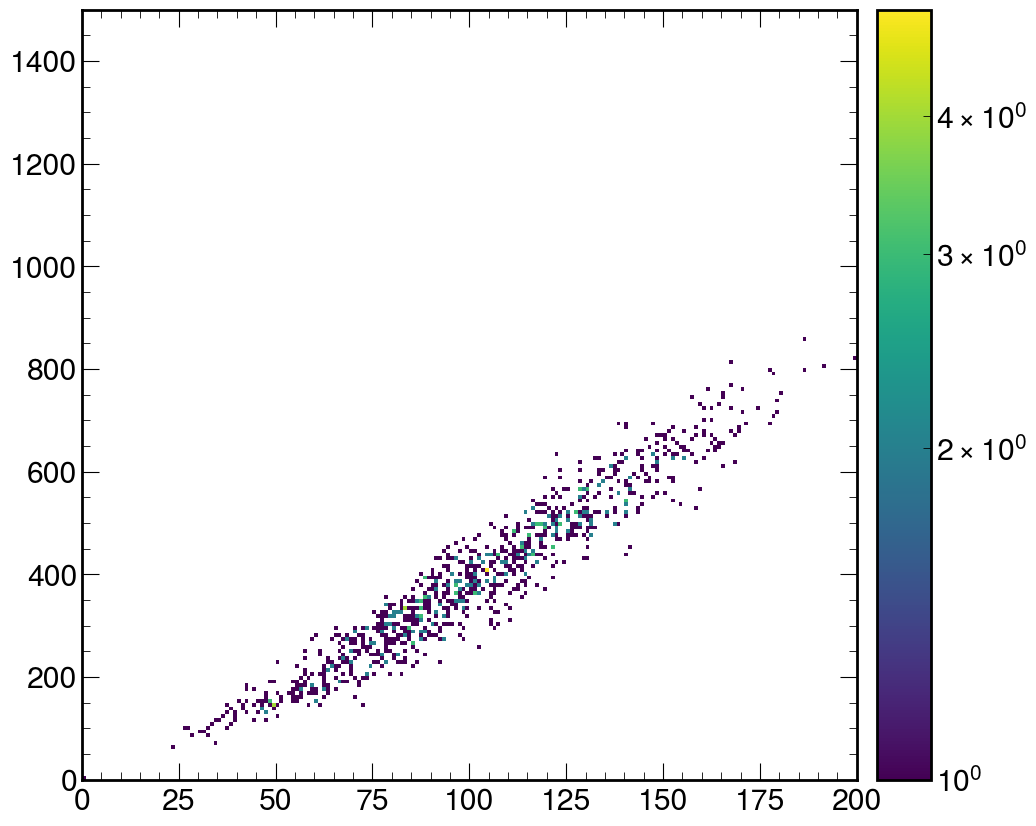

In [44]:
charge = [event.total_log_charge_pc for event in run.events]
nhit = [event.nhits for event in run.events]

print(nhits)

# prompt_charge = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==0]
# prompt_nhit = [event.nhits for event in run.events if event.trigger_type==0]

# early_follower_charge = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]
# early_follower_nhit = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]

# late_follower_charge = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us >= 4]
# late_follower_nhit = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us >= 4]


#x = np.linspace(0,200,100)


#fig, ax = plt.subplots(1,4, figsize=(15,5))
#fig.tight_layout()
hep.hist2dplot(np.histogram2d(nhits, charge, bins=(200,200), range=((0,200),(0,1500))), norm='log')
#plt.set_title("All Triggers")
#ax[0].plot(x,line(x,0.022,108,90),'-',linewidth=2,color='red')




# hep.hist2dplot(np.histogram2d(prompt_nhit, prompt_charge, bins=(200,200), range=((0,200),(0,1500))), ax=ax[1], norm='log')
# ax[1].set_title("Prompt Triggers")
# ax[1].set_xlabel("NHits")
# ax[1].set_ylabel("Charge (pc)")

# hep.hist2dplot(np.histogram2d(early_follower_nhit, early_follower_charge, bins=(200,200), range=((0,200),(0,1500))), ax=ax[2], norm='log')
# ax[2].set_title("Early Follower Triggers")
# ax[2].set_xlabel("NHits")   
# ax[2].set_ylabel("Charge (pc)")

# hep.hist2dplot(np.histogram2d(late_follower_nhit, late_follower_charge, bins=(200,200), range=((0,200),(0,1500))), ax=ax[3], norm='log')
# ax[3].set_title("Late Follower Triggers")
# ax[3].set_xlabel("NHits")
# ax[3].set_ylabel("Charge (pc)")

# Cut on nhit and charge aboce 100 nhit to isolate the three regions
# Top is prompt muons
# Bottoms is early michels
# What is middle? Late something

In [7]:
# early_total_charge = [event.total_gaussian_charge_pc for event in run.events if event.time_since_last_trigger_us<3]
# late_total_charge = [event.total_gaussian_charge_pc for event in run.events if event.time_since_last_trigger_us>3]

# ec, eb = np.histogram(early_total_charge, bins=50, range=(0,500))
# lc, lb = np.histogram(late_total_charge, bins=50, range=(0,500))
# res = lc-ec
# centers = (eb[1:]+eb[:-1])/2

# plt.hist(early_total_charge, bins=50, range=(0,500), histtype='step', label='Early - Decaying Muon');
# plt.hist(late_total_charge, bins=50, range=(0,500), histtype='step', label='Late - Crossing Muon');
# plt.plot(centers, res, label='Difference',)
# plt.legend()
# plt.yscale('log')

In [8]:
# for event in run.events:
#     event.print()


Text(1, 0, 'Total NHits per Event')

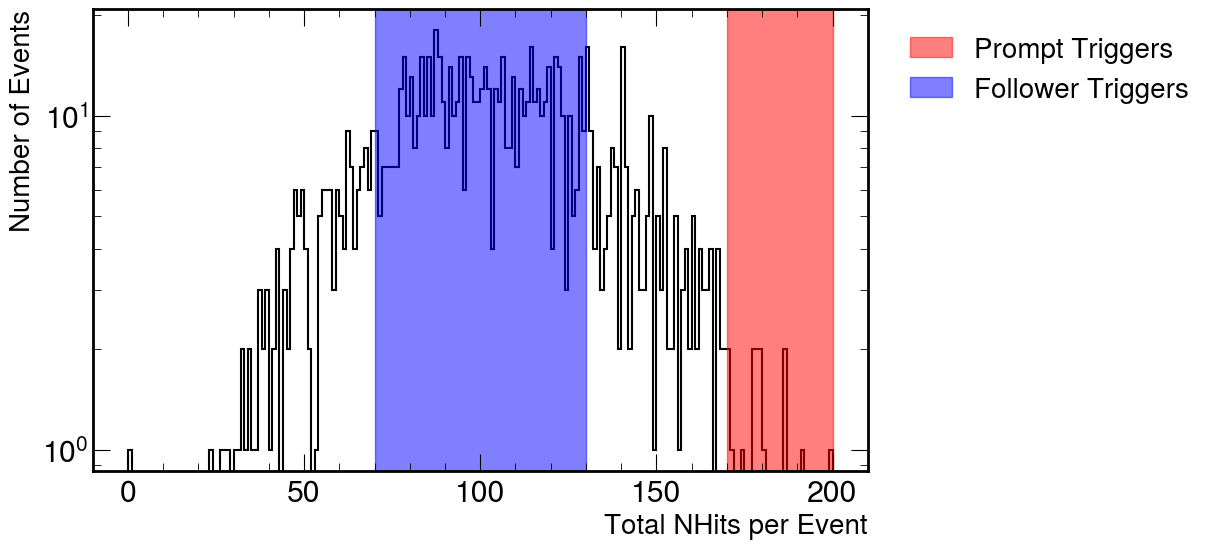

In [9]:
nhits = run.get_nhits()

plt.figure(figsize=(10, 6))
hep.histplot(np.histogram(nhits, bins=200, range=(0, 200)), color='black')
plt.axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Triggers')
plt.axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Triggers')
plt.legend(loc='upper right',bbox_to_anchor=(1.45, 1),fontsize=20)
#plt.ylim(1e3,1e5)
plt.yscale('log')
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel('Total NHits per Event', fontsize=20)

630 630


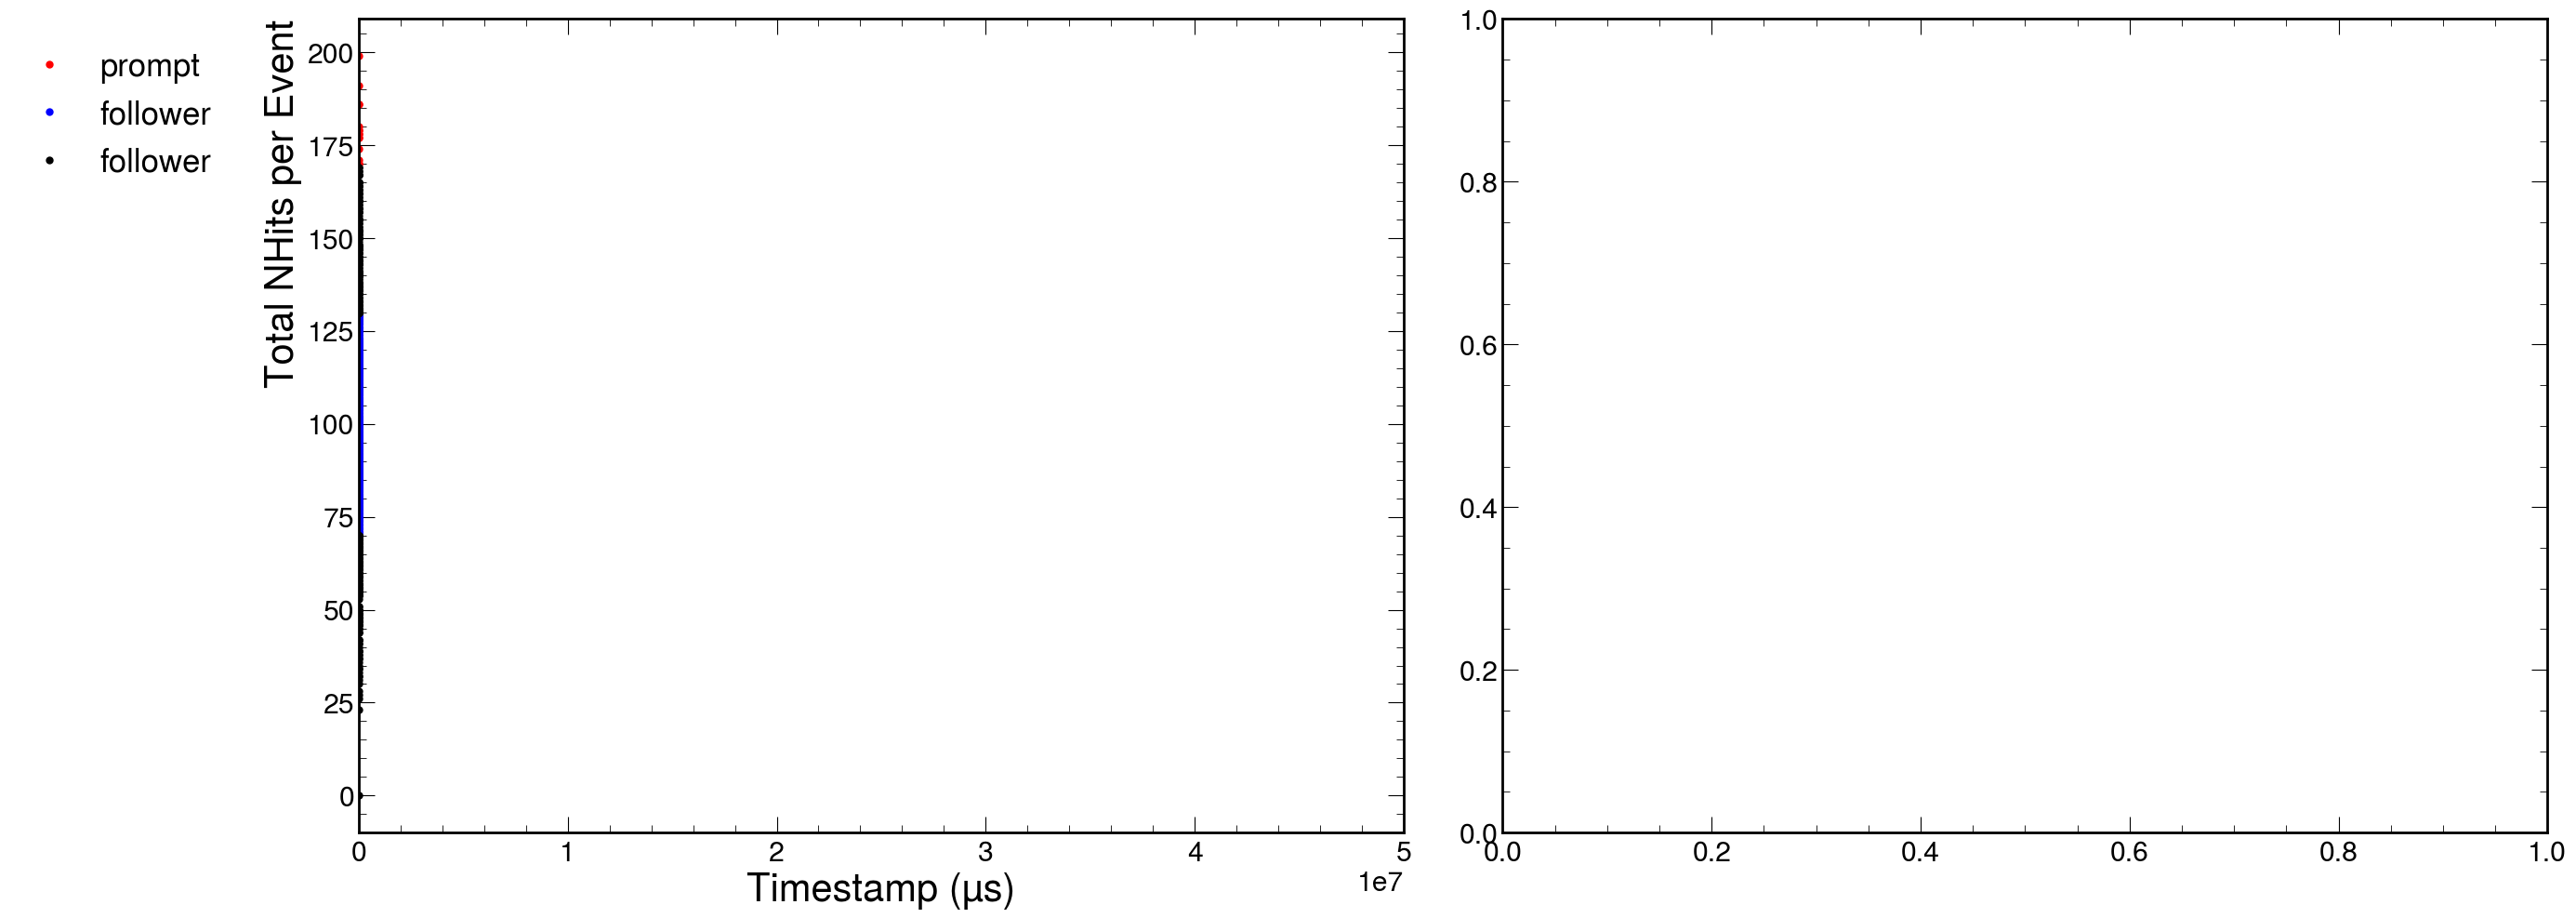

In [10]:
ts_prompt = [event.timestamp_us for event in run.events if event.trigger_type==0]
ts_follower = [event.timestamp_us for event in run.events if event.trigger_type==1]
ts_bad = [event.timestamp_us for event in run.events if event.trigger_type==None]

deltat = [event.time_since_last_trigger_us for event in run.events if event.trigger_type==1]
deltat_follower = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1]
print(len(deltat),len(deltat_follower))

nhits_prompt = [event.nhits for event in run.events if event.trigger_type==0]
nhits_follower = [event.nhits for event in run.events if event.trigger_type==1]
nhits_bad = [event.nhits for event in run.events if event.trigger_type==None]

fig, ax = plt.subplots(1,2,figsize=(25, 10))
fig.tight_layout()
ax[0].plot(ts_prompt, nhits_prompt, 'o', markersize=5, label='prompt', color='red')
ax[0].plot(ts_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
ax[0].plot(ts_bad, nhits_bad, 'o', markersize=5, label='follower', color='black')
ax[0].set_xlabel('Timestamp (µs)', loc='center',fontsize=30)
ax[0].set_ylabel('Total NHits per Event', fontsize=30)
ax[0].set_xlim(0, 5e7)
ax[0].legend(loc='upper left',bbox_to_anchor=(-0.35, 1),fontsize=25)
#ax[1].plot(deltat_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
# hd = ax[1].hist2d(deltat_follower, nhits_follower, bins=(30, 30), range=((1, 200), (0,200)),norm='log', cmap='Blues')
# ax[1].set_xlabel('Time Since Last Prompt Trigger (µs)', loc='center', fontsize=30)
# ax[1].set_xlim(1,200)
#ax[1].set_ylim(follower_nhit_range[0], follower_nhit_range[1])  
# fig.colorbar(hd[3],ax=ax[1])
#ax[2].plot(deltat, nhits_follower, 'o', markersize=5, label='follower', color='blue')
# hdf = ax[2].hist2d(deltat, nhits_follower, bins=(19, 20), range=((1, 20), (0, 200)), cmap='Blues')
# ax[2].set_xlabel('Time since last trigger (us)', fontsize=20)
# ax[2].set_xlim(1,20)
# fig.colorbar(hdf[3],ax=ax[2])

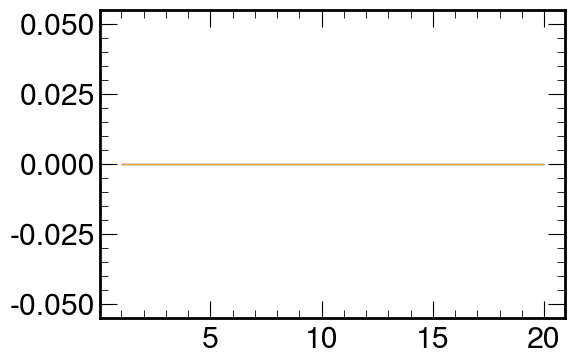

In [11]:
plt.figure(figsize=(6, 4))
plt.hist(deltat, bins=19, range=(1, 20), histtype='step', label='Follower')
plt.hist(deltat_follower, bins=19, range=(1, 20), histtype='step', label='Follower');

In [12]:

def fit_decay_hist(data,bins=19,range=(0.5,15.5),tau_guess=2):

    bins=5

    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    sigma = np.sqrt(counts)

    def decay_model(t, A, tau, B):
        return (A / tau) * np.exp(-t / tau) + B
    
    # Initial guess for the parameters
    A_guess = np.max(counts) * (range[1] - range[0]) / bins
    B_guess = np.min(counts)
    p0 = [A_guess, tau_guess, B_guess]

    popt, pcov = curve_fit(decay_model, bin_centers, counts, sigma=sigma, absolute_sigma=True, p0=p0, maxfev=100000) 

    A_fit, tau_fit, B_fit = popt
    A_err, tau_err, B_err = np.sqrt(np.diag(pcov))

    residuals = counts - decay_model(bin_centers, *popt)
    chi2 = np.sum((residuals / sigma) ** 2)
    dof = len(counts) - len(popt)
    chi2_red = chi2 / dof

    print("Fit results:")
    print(f"A = {A_fit:.3f} ± {A_err:.3f}")
    print(f"tau = {tau_fit:.3f} ± {tau_err:.3f}")
    print(f"B = {B_fit:.3f} ± {B_err:.3f}")
    print(f"Chi2 = {chi2:.3f}")
    print(f"Chi2/dof = {chi2_red:.3f}")

    plt.figure(figsize=(10, 6))
    plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', color='black', label='Data')
    t_fine = np.linspace(*range, 1000)
    plt.plot(t_fine, decay_model(t_fine, *popt), color='red', label=fr'WLS Fit: $\tau$ = {tau_fit:.3f} +/- {tau_err:.3f} µs')
    plt.xlabel('$\Delta$T (µs)', fontsize=20)
    plt.ylabel(f"Counts / {(range[-1]-range[0])/bins:.3f} µs",fontsize=20)
    plt.title(f" $\Delta$T = Time Since Last Prompt Trigger",fontsize=20)
    plt.grid(True)
    #plt.yscale('log')
    #plt.axvspan(0.5,3, color='blue', alpha=0.5, label='Selected Events')
    plt.legend(fontsize=15)
    plt.show()
    

#deltat_follower = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<10]
#fit_decay_hist(deltat_follower)



In [13]:
total_digit_charge_pc = [event.total_digit_charge_pc for event in run.events if event.trigger_type!=None] 
total_log_charge_pc = [event.total_log_charge_pc for event in run.events if event.trigger_type!=None]
total_gaussian_charge_pc = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type!=None]

print(len(total_log_charge_pc),len(total_digit_charge_pc), len(total_gaussian_charge_pc))
print(total_digit_charge_pc[0])
print(total_log_charge_pc[0])
print(total_digit_charge_pc[0])

645 645 645
1104.7851562500016
513.6364040757976
1104.7851562500016


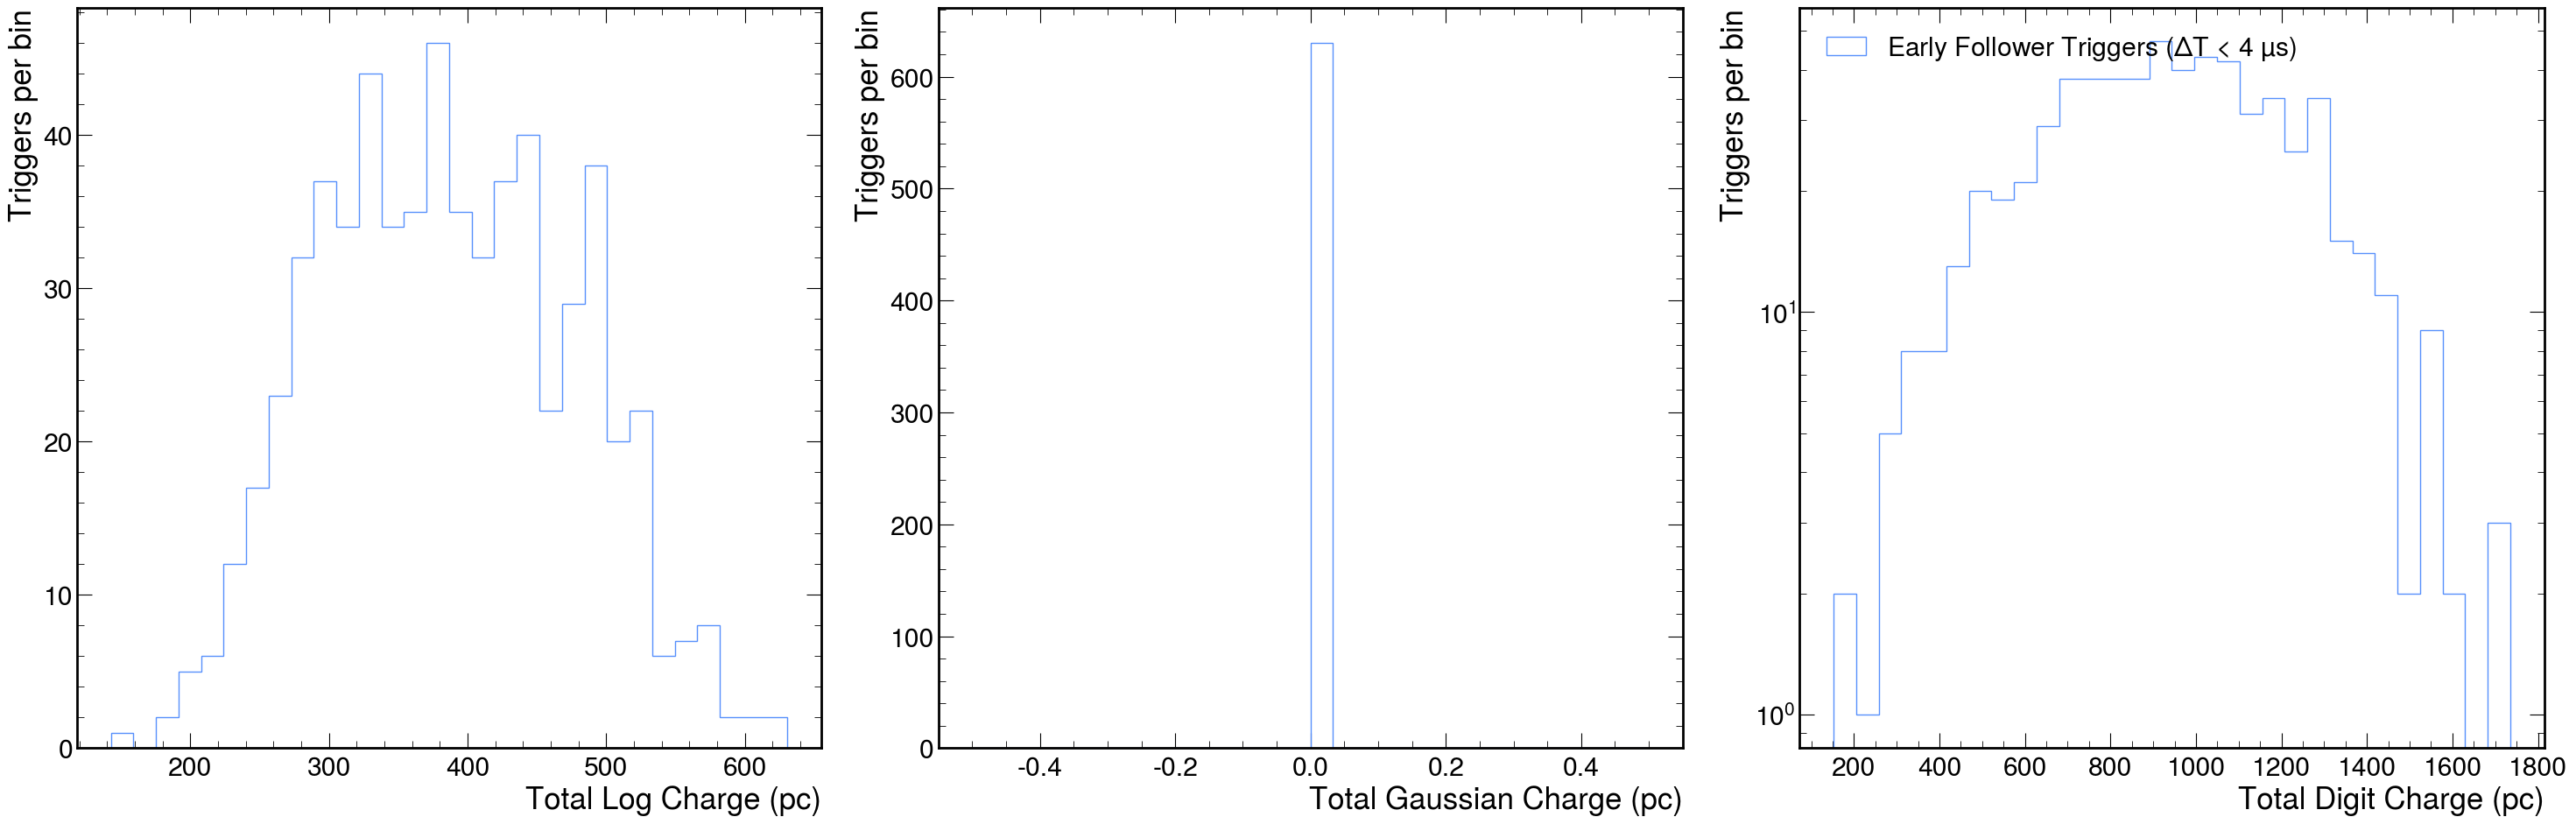

In [43]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),sharey=False,tight_layout=True)
fontsize = 25
bins=30
upper_charge=1500
#log_bins = np.logspace(np.log10(1),np.log10(upper_charge), bins)

total_log_charge_pc_follower_early = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
total_log_charge_pc_follower_late = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_log_charge_pc_prompt = [event.total_log_charge_pc for event in run.events if event.trigger_type==0]

ax[0].hist(total_log_charge_pc_follower_early, bins=bins, histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[0].hist(total_log_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[0].hist(total_log_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[0].set_xlabel('Total Log Charge (pc)', fontsize=fontsize)
ax[0].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_xlim(3e1,1e4)
#ax[0].legend()

total_gaussian_charge_pc_follower_early = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
total_gaussian_charge_pc_follower_late = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_gaussian_charge_pc_prompt = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==0]

ax[1].hist(total_gaussian_charge_pc_follower_early, bins=bins, histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[1].hist(total_gaussian_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[1].hist(total_gaussian_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[1].set_xlabel('Total Gaussian Charge (pc)', fontsize=fontsize)
ax[1].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].set_xlim(3e1,1e4)
#ax[1].legend()

total_digit_charge_pc_follower_early = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
total_digit_charge_pc_follower_late = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_digit_charge_pc_prompt = [event.total_digit_charge_pc for event in run.events if event.trigger_type==0]

ax[2].hist(total_digit_charge_pc_follower_early, bins=bins, histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[2].hist(total_digit_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[2].hist(total_digit_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[2].set_xlabel('Total Digit Charge (pc)', fontsize=fontsize)
ax[2].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[2].set_xlim(3e1,2e4)
#ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].legend(loc='upper left')


In [16]:
digits = [event.digit_charge_pc for event in run.events]

print(digits[1])
fds = digits[1]

[2.03, 1.96, 0.635, 0.635, 1.29, 0.806, ..., 2, 1.15, 2.62, 3.41, 8.84, 7.83]


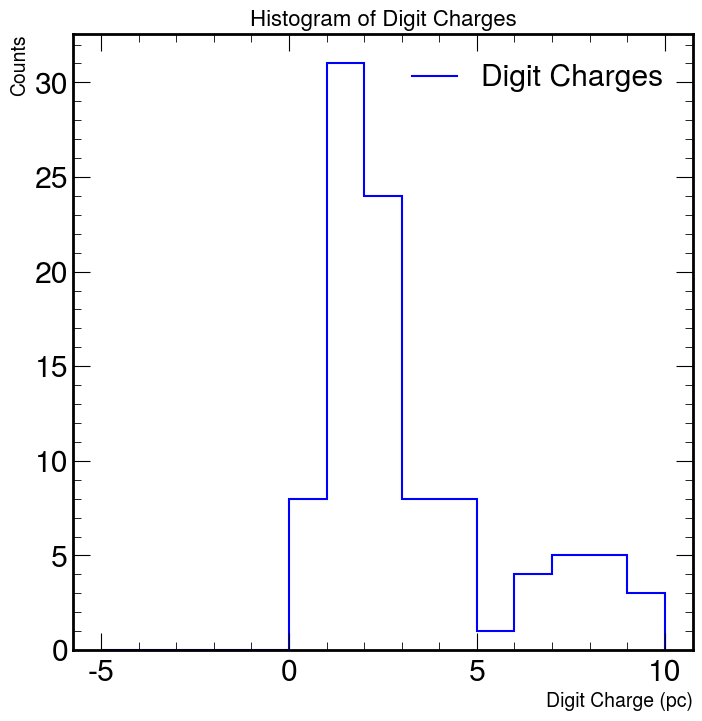

8.631134033203137


In [17]:
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

# Assuming `fds` is your data
counts, bin_edges = np.histogram(fds, bins=15, range=(-5,10))

# Plot the histogram
plt.figure(figsize=(8, 8))
hep.histplot(counts, bins=bin_edges, color='blue', label='Digit Charges')
plt.xlabel('Digit Charge (pc)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Histogram of Digit Charges', fontsize=16)
plt.legend()
plt.show()
print(np.mean(fds))

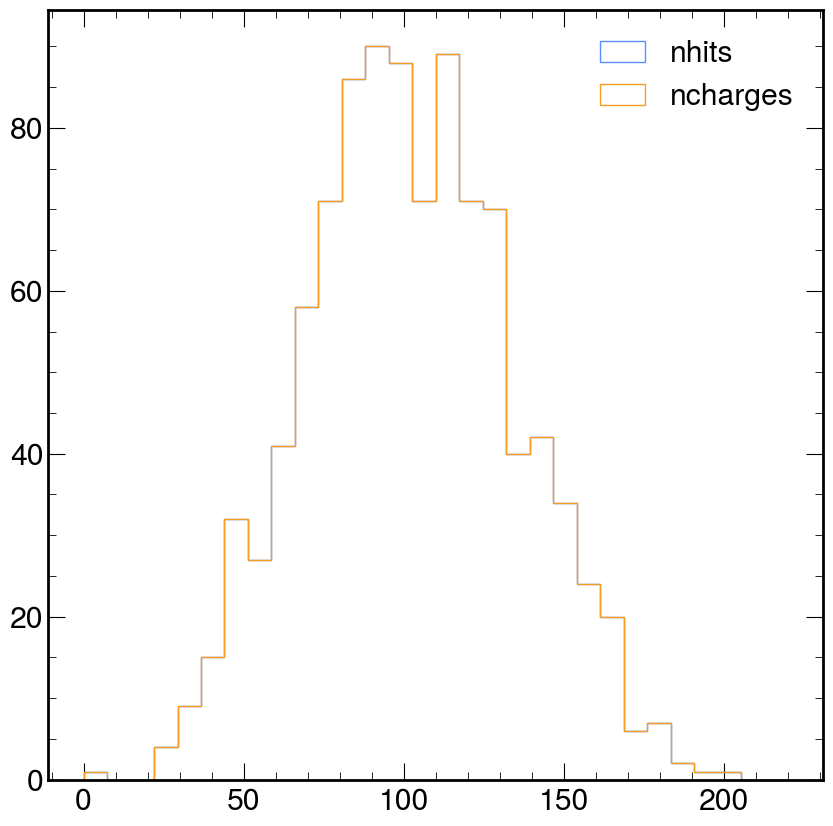

In [18]:
nhits = [event.nhits for event in run.events]# if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]
charges = [event.digit_charge_pc for event in run.events]# if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]

ncharges = []
for c in charges:
    ncharges.append(len(c))

plt.hist(nhits,bins=30,range=(0,220),histtype='step',label='nhits')
plt.hist(ncharges,bins=30,range=(0,220),histtype='step',label='ncharges')
plt.legend()



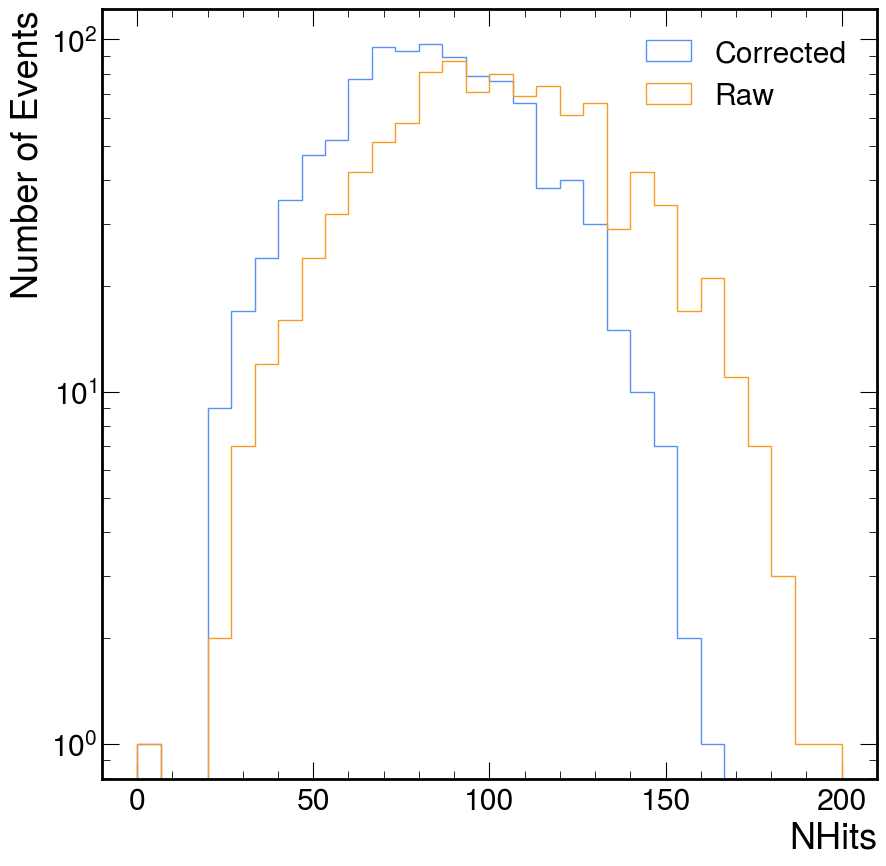

In [41]:
import matplotlib.pyplot as plt

# Step 1: Gather all digit PMT IDs per event
digit_pmt_ids = [event.digit_pmt_id for event in run.events]

# Step 2: Filter for online PMTs in each event
corrected_digit_pmt_ids = [
    [pmt_id for pmt_id in event_ids if run.pmt_is_online[pmt_id]]
    for event_ids in digit_pmt_ids
]

# Step 3: Count hits per event (before and after correction)
ndigits = [len(event_ids) for event_ids in digit_pmt_ids]
ndigits_corr = [len(event_ids) for event_ids in corrected_digit_pmt_ids]

# Step 4: Plot histogram of corrected digit counts
plt.hist(ndigits_corr, bins=30,range=(0,200), histtype='step', label='Corrected')
plt.hist(ndigits, bins=30, range=(0,200), histtype='step', label='Raw')
plt.xlabel("NHits")
plt.ylabel("Number of Events")
plt.legend()
plt.yscale('log')
plt.show()



(array([17., 32., 45., 57., 58., 48., 66., 49., 47., 52., 63., 59., 43.,
        49., 63., 44., 68., 63., 49., 28.]),
 array([-894.41112999, -806.58426402, -718.75739804, -630.93053207,
        -543.10366609, -455.27680012, -367.44993414, -279.62306817,
        -191.7962022 , -103.96933622,  -16.14247025,   71.68439573,
         159.5112617 ,  247.33812768,  335.16499365,  422.99185962,
         510.8187256 ,  598.64559157,  686.47245755,  774.29932352,
         862.1261895 ]),
 <BarContainer object of 20 artists>)

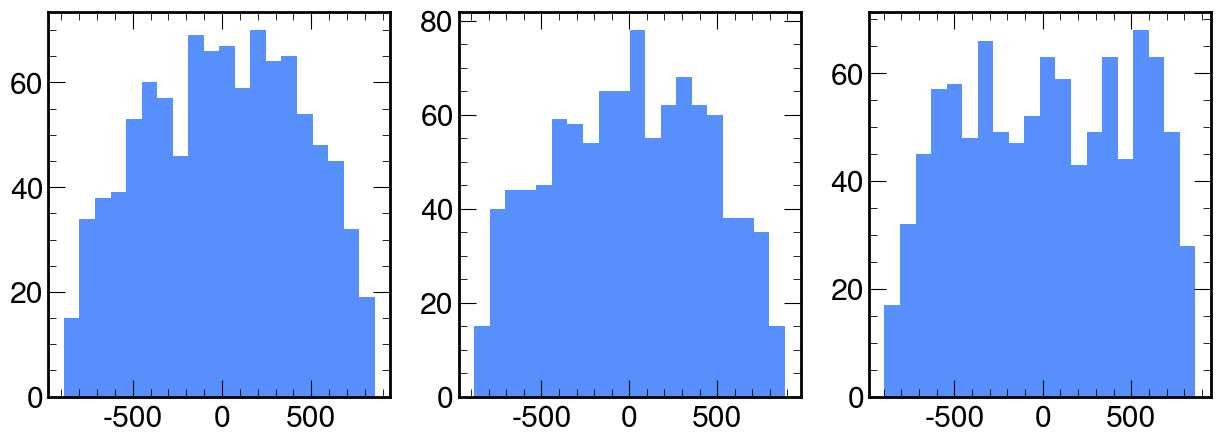

In [20]:
mcx = [event.mcx for event in run.events]
mcy = [event.mcy for event in run.events] 
mcz = [event.mcz for event in run.events]


fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].hist(mcx,bins=20)
ax[1].hist(mcy,bins=20)
ax[2].hist(mcz,bins=20)

241
241
241


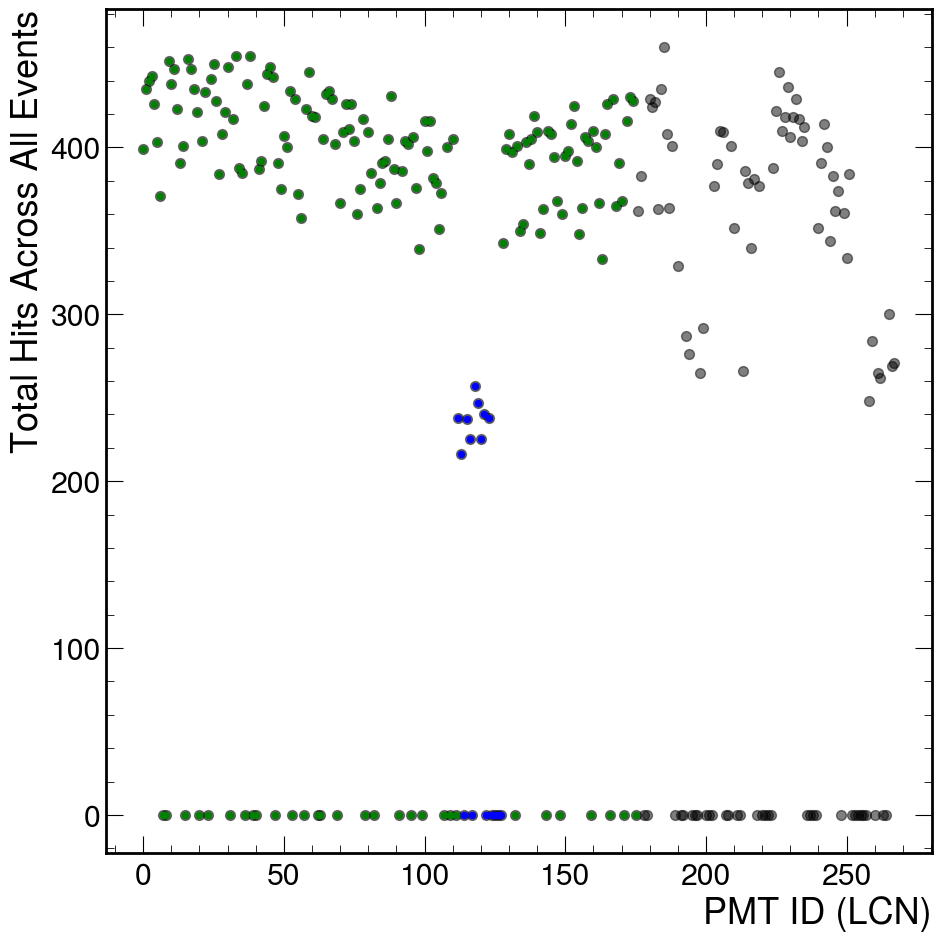

In [21]:
pmt_id_to_ch = dict(zip(run.pmt_id, run.pmt_ch))

print(len(run.pmt_id))
print(len(run.pmt_is_online))
print(len(pmt_id_to_ch))

barrel_channels = []
barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
barrel_channels.extend([16 * board + i for board in barrel_boards for i in range(16)])

dichroic_channels = []
dichroic_boards = [7]
dichroic_channels.extend([16 * board + i for board in dichroic_boards for i in range(16)])


# Assuming each PMT ID maps directly to its LCN (i.e., pmt_id == lcn)
pmt_hit_counts = np.zeros(np.max(run.pmt_ch), dtype=int)


# Count hits for online PMTs
for event in run.events:
    if True:
    # if -500<event.mcx<500 and -500<event.mcy<500 and -500<event.mcz<500:
        for pmt_id,time in zip(event.digit_pmt_id, event.digit_time_ns):
            if run.pmt_is_online[pmt_id] and -10<time<10:
                pmt_hit_counts[pmt_id_to_ch[pmt_id]] += 1

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(range(len(pmt_hit_counts)), pmt_hit_counts, s=50, alpha=0.5, color='black', label='All Channels')

# Optional: highlight barrel and dichroic
plt.scatter(barrel_channels, pmt_hit_counts[barrel_channels], s=20, alpha=1, color='green', label='Barrel Channels')
plt.scatter(dichroic_channels, pmt_hit_counts[dichroic_channels], s=20, alpha=1, color='blue', label='Dichroic Channels')

plt.xlabel("PMT ID (LCN)")
plt.ylabel("Total Hits Across All Events")
plt.tight_layout()




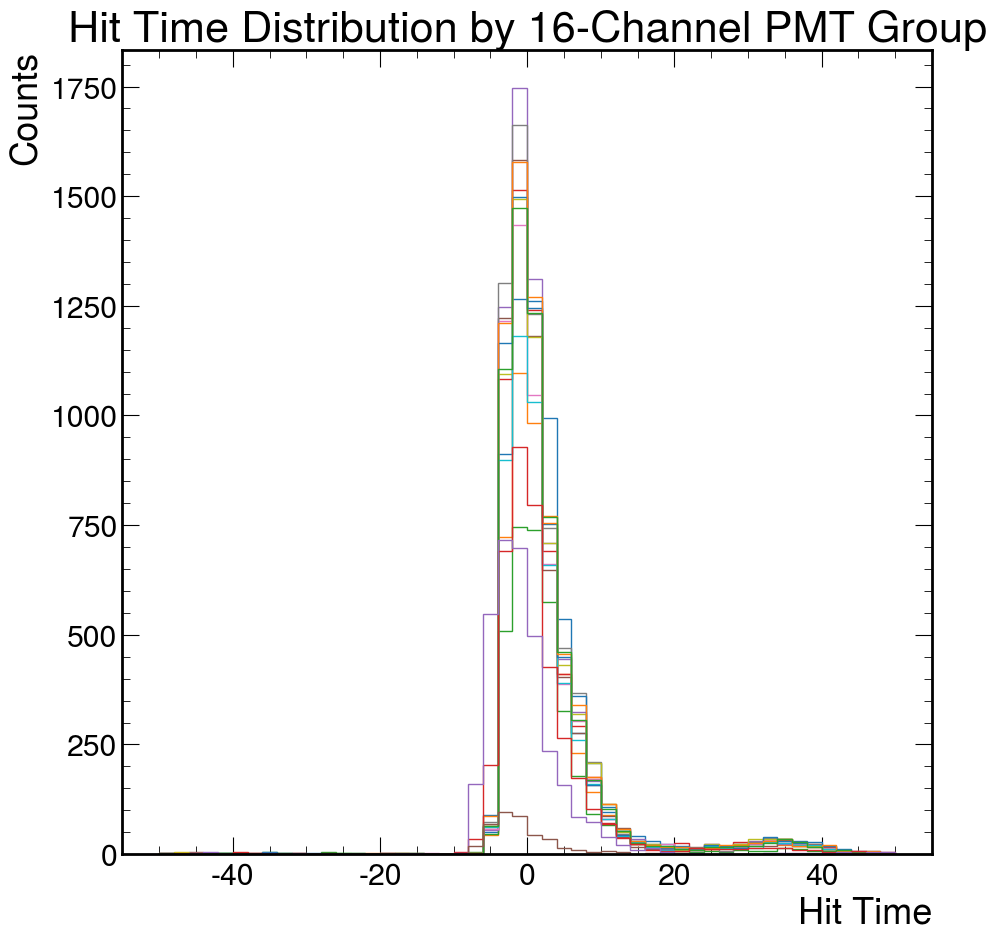

In [22]:
grouped_hit_times = {}

for event in run.events:
    for pmt_id, time in zip(event.digit_pmt_id, event.digit_time_ns):
        if run.pmt_is_online[pmt_id]:
            group = pmt_id //16 
            if group not in grouped_hit_times:
                grouped_hit_times[group] = []
            grouped_hit_times[group].append(time)

# Convert to NumPy array if needed
for group in grouped_hit_times:
    grouped_hit_times[group] = np.array(grouped_hit_times[group])

plt.figure(figsize=(10, 10))

colors = plt.cm.tab10.colors  # color palette
for i, (group, times) in enumerate(sorted(grouped_hit_times.items())):
    plt.hist(times, bins=50, range=(-50,50), histtype='step', label=f'PMTs {group*16}-{group*16+15}', color=colors[i % len(colors)])

plt.xlabel('Hit Time')
plt.ylabel('Counts')
#plt.legend()
plt.title('Hit Time Distribution by 16-Channel PMT Group')
plt.tight_layout()
plt.show()

[True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, False, False, True, True, False, True, True, False, False, True, True, True, False, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, True, True, True, True, False, True, False, True, True, True, 

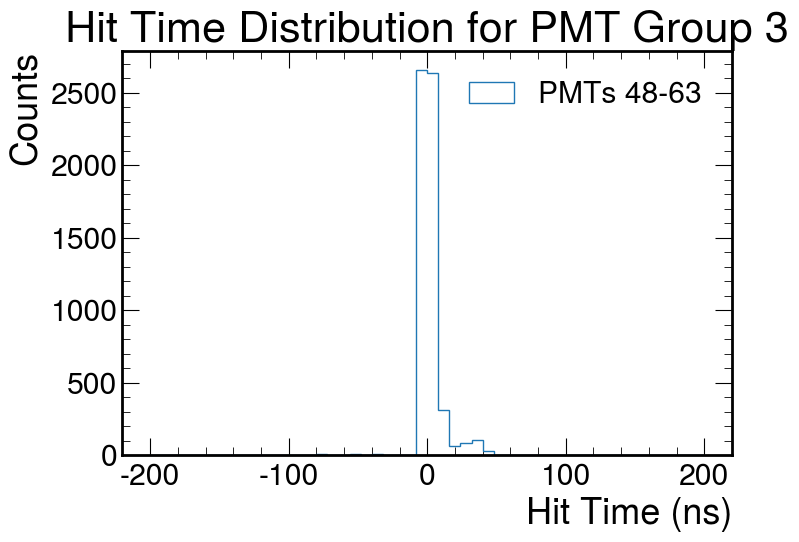

In [23]:
#= [True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,True,True,False,False,True,True,False,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,True,False,True,True,True,False,True,True,True,True,True,True,True,False,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,False,False,True,True,True,True,False,True,True,False,False,False,True,True,False,False,False,True,False,True,True,False,False,True,True,True,True,True,False,True]i
print(run.pmt_is_online)

group_to_plot = 3  # Change this to whichever group you want

if group_to_plot in grouped_hit_times:
    plt.figure(figsize=(8, 6))
    times = grouped_hit_times[group_to_plot]
    plt.hist(times, bins=50, range=(-200, 200), histtype='step', 
             label=f'PMTs {group_to_plot*16}-{group_to_plot*16+15}',
             color='tab:blue')
    
    plt.xlabel('Hit Time (ns)')
    plt.ylabel('Counts')
    plt.title(f'Hit Time Distribution for PMT Group {group_to_plot}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Group {group_to_plot} not found in data.")

[True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, False, False, True, True, False, True, True, False, False, True, True, True, False, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, True, True, True, True, False, True, False, True, True, True, 

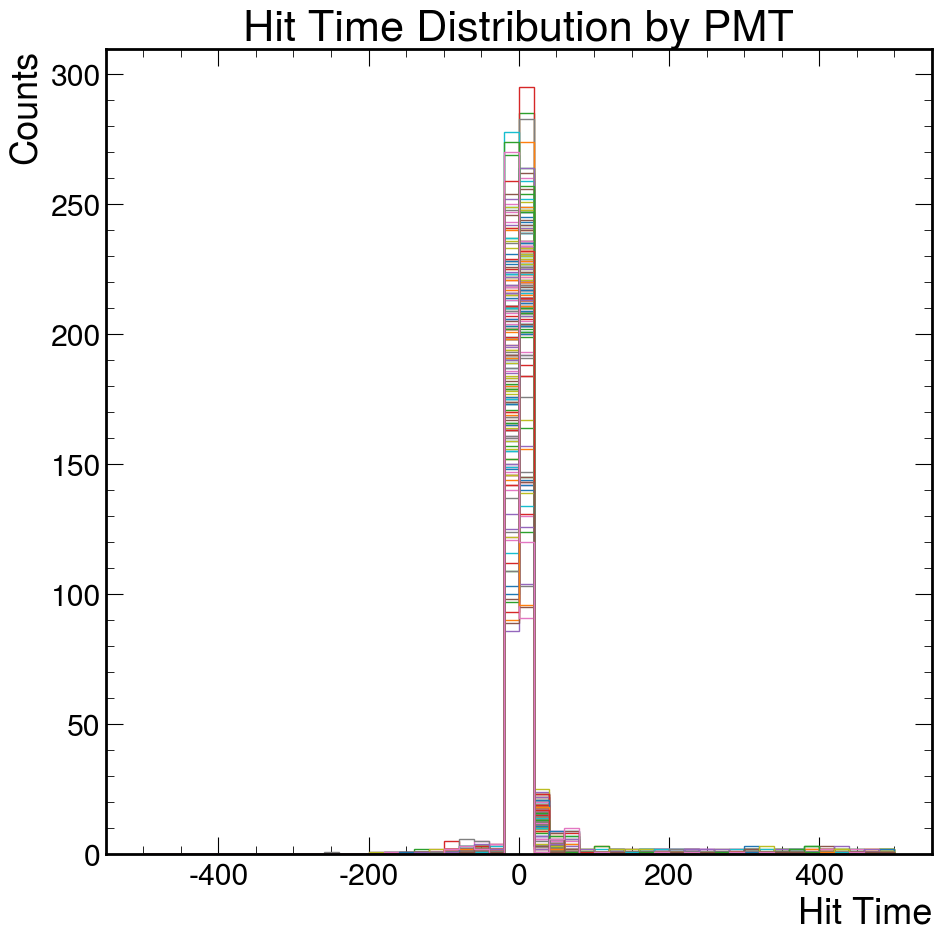

In [24]:

print(run.pmt_is_online)
grouped_hit_times = {}

for event in run.events:
    for pmt_id, time in zip(event.digit_pmt_id, event.digit_time_ns):
        if run.pmt_is_online[pmt_id]:#and -30<time<10:
            group = pmt_id 
            if group not in grouped_hit_times:
                grouped_hit_times[group] = []
            grouped_hit_times[group].append(time)

# Convert to NumPy array if needed
for group in grouped_hit_times:
    grouped_hit_times[group] = np.array(grouped_hit_times[group])

plt.figure(figsize=(10, 10))

colors = plt.cm.tab10.colors  # color palette
for i, (group, times) in enumerate(sorted(grouped_hit_times.items())):
    plt.hist(times, bins=50, range=(-500,500), histtype='step', label=f'PMTs {group}', color=colors[i % len(colors)])

plt.xlabel('Hit Time')
plt.ylabel('Counts')
#plt.legend()
plt.title('Hit Time Distribution by PMT')
plt.tight_layout()
plt.show()


In [25]:


group_to_plot = 7 # Change this to whichever group you want

if group_to_plot in grouped_hit_times:
    plt.figure(figsize=(8, 6))
    times = grouped_hit_times[group_to_plot]
    plt.hist(times, bins=100, range=(-200, 200), histtype='step', 
             label=f'PMTs {group_to_plot}',
             color='tab:blue')
    
    plt.xlabel('Hit Time (ns)')
    plt.ylabel('Counts')
    plt.title(f'Hit Time Distribution for PMT {group_to_plot}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Group {group_to_plot} not found in data.")

Group 7 not found in data.


In [26]:
print(len(grouped_hit_times))

197


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  6.,  9.,  7., 15., 17.,
        12., 21., 25., 25., 29., 28., 44., 46., 53., 48., 42., 50., 42.,
        46., 40., 48., 47., 43., 24., 49., 18., 22., 30., 17., 19., 17.,
        10., 14., 11.,  7.,  1.,  6.,  1.,  2.,  1.,  0.,  1.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 [<matplotlib.patches.Polygon at 0x77fd9eee20a0>])

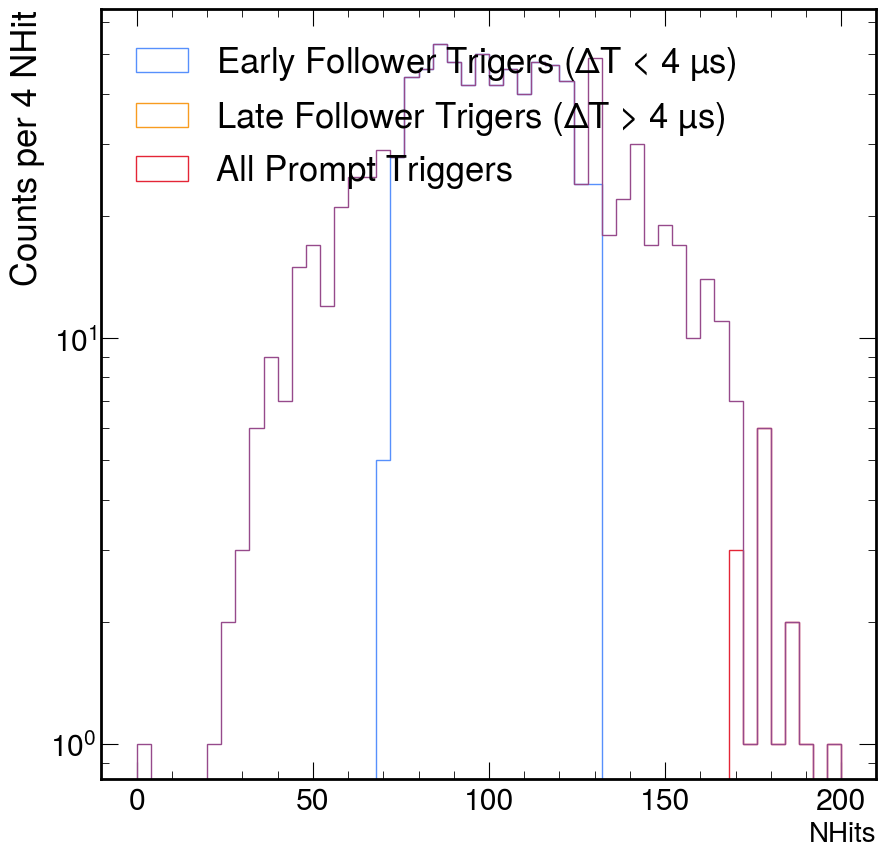

In [27]:



nhit_follower_early = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
nhit_follower_late = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
#nhit_follower_wierd = [event.nhits for event in run.events if event.trigger_type==1 and 8>event.time_since_last_prompt_trigger_us>3]
nhit_prompt = [event.nhits for event in run.events if event.trigger_type==0]

#plt.hist(total_log_charge_pc_follower, bins=50, range=(0,500), histtype='step', label='Follower');
plt.hist(nhit_follower_early, bins=50, range=(0,200), histtype='step', label='Early Follower Trigers ($\Delta$T < 4 µs)');
plt.hist(nhit_follower_late, bins=50, range=(0,200), histtype='step', label='Late Follower Trigers ($\Delta$T > 4 µs)');
#plt.hist(nhit_follower_wierd, bins=50, range=(0,200), histtype='step', label='Follower Wierd');
plt.hist(nhit_prompt, bins=50, range=(0,200), histtype='step', label='All Prompt Triggers');
plt.xlabel('NHits', fontsize=20)
plt.ylabel('Counts per 4 NHit', fontsize=fontsize)
plt.legend(loc='upper left',fontsize=fontsize)
plt.yscale('log')


plt.hist(nhits,bins=50,range=(0,200),histtype='step')

In [28]:
#michels = [event for event in run.events]# if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.total_log_charge_pc<120]


charges = [event.total_log_charge_pc for event in michels]

plt.figure(figsize=(8, 6))
hep.histplot(np.histogram(charges, bins=30), color='black', label='Michel Candidates')


NameError: name 'michels' is not defined

In [ ]:
times = [event.digit_time_ns for event in michels]
print(times[0])

plt.figure(figsize=(8, 6))


times = ak.flatten(times) 


plt.hist(times, color='black', bins=500, range=(-200,200), label='Michel Candidates')
plt.yscale('log')

In [ ]:
# Figure out which hits are coming from which channels
print(run.pmt_id)

print(run.pmt_ch)

# Then figure out cable delays for each channels

# Then compare data across boards

In [ ]:

plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_follower_early, total_gaussian_charge_pc_follower_early, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Blues', norm='log')

In [ ]:
plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_follower_late, total_gaussian_charge_pc_follower_late, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Reds', norm='log')

In [ ]:
plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_prompt, total_gaussian_charge_pc_prompt, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Greens', norm='log')


In [ ]:
nhits = [event.nhits for event in run.events]
charges = [event.total_log_charge_pc for event in run.events]

charge_log_bins = np.logspace(np.log10(2),np.log10(1500), bins)
nhit_log_bins = np.logspace(np.log10(2),np.log10(200), bins)

plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(200, 200), range=((0, 200), (0, 1500))), norm='log')
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

In [ ]:
early_follower_times = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<30]
late_follower_times = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>30]


fit_decay_hist(early_follower_times,bins=29,range=(0.5,30),tau_guess=2)
fit_decay_hist(late_follower_times,bins=30,range=(100,400),tau_guess=200)

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and 4<event.time_since_last_prompt_trigger_us<7]
charges = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and 4<event.time_since_last_prompt_trigger_us<7]
plt.figure(figsize=(6, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(100, 100), range=((0, 200), (0, 800))), cmap='Blues', norm='log')
plt.title("Follower Triggers with 4 < $\Delta$T < 7 µs", fontsize=20)
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and 100<event.time_since_last_prompt_trigger_us<400]
charges = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and 100<event.time_since_last_prompt_trigger_us<400]
plt.figure(figsize=(6, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(100, 100), range=((0, 200), (0, 800))), cmap='Blues', norm='log')
plt.title("Follower Triggers with 0.5 < $\Delta$T < 4 µs", fontsize=20)
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

In [ ]:
print("pmt_ch = ",run.pmt_ch)
print("pmt_id = ",run.pmt_id)

print(len(run.pmt_is_online))



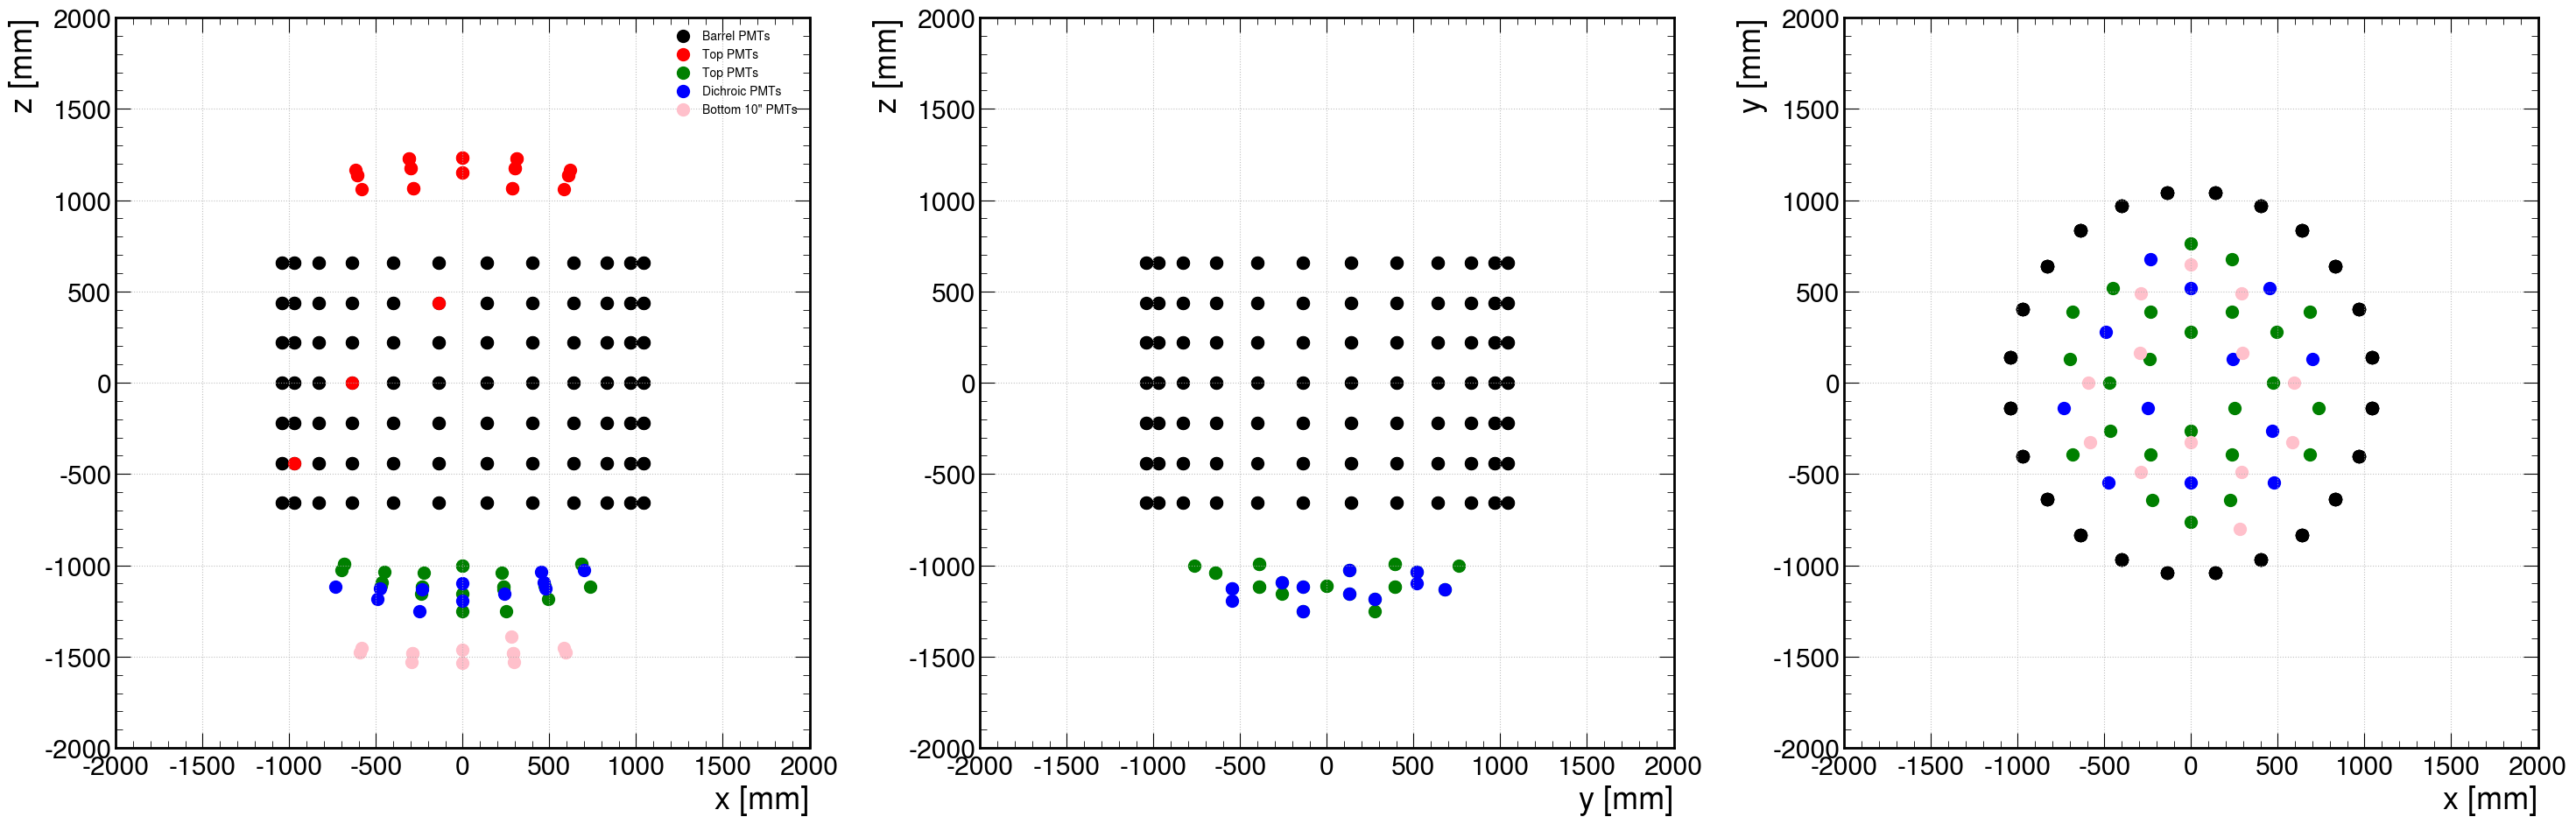

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

# Define PMT channels
barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
barrel_channels = [16 * board + i for board in barrel_boards for i in range(16)]


special_channels = np.arange(0, 36, 1)

top_boards =  [12, 13]
top_channels = [16 * board + i for board in top_boards for i in range(16)]

dichroic_boards = [7]
dichroic_channels = [16 * board + i for board in dichroic_boards for i in range(16)]

bottom_boards = [14, 15]
bottom_channels = [16 * board + i for board in bottom_boards for i in range(16)]

behind_boards = [16]
behind_channels = [16 * board + i for board in behind_boards for i in range(13)]

# Create channel to ID mapping
ch2id = dict(zip(run.pmt_ch, run.pmt_id))

# Convert channel lists to ID lists
barrel_ids = [ch2id[ch] for ch in barrel_channels if ch in ch2id]
bottom_ids = [ch2id[ch] for ch in bottom_channels if ch in ch2id]
dichroic_ids = [ch2id[ch] for ch in dichroic_channels if ch in ch2id]
special_ids = [ch2id[ch] for ch in special_channels if ch in ch2id]
top_ids = [ch2id[ch] for ch in top_channels if ch in ch2id]
behind_ids = [ch2id[ch] for ch in behind_channels if ch in ch2id]

# Plot X-Z view
ax[0].scatter(run.pmtx[barrel_ids], run.pmtz[barrel_ids], color='black', label="Barrel PMTs", s=100)
ax[0].scatter(run.pmtx[top_ids], run.pmtz[top_ids], color='red', label="Top PMTs", s=100)
ax[0].scatter(run.pmtx[bottom_ids], run.pmtz[bottom_ids], color='green', label="Top PMTs", s=100)
ax[0].scatter(run.pmtx[dichroic_ids], run.pmtz[dichroic_ids], color='blue', label='Dichroic PMTs', s=100)
ax[0].scatter(run.pmtx[behind_ids], run.pmtz[behind_ids], color='pink', label='Bottom 10" PMTs', s=100)

# Plot Y-Z view
ax[1].scatter(run.pmty[barrel_ids], run.pmtz[barrel_ids], color='black', s=100)
# ax[1].scatter(run.pmty[top_ids], run.pmtz[top_ids], color='red', label="Top PMTs", s=100)
ax[1].scatter(run.pmty[bottom_ids], run.pmtz[bottom_ids], color='green', label="Top PMTs", s=100)
ax[1].scatter(run.pmty[dichroic_ids], run.pmtz[dichroic_ids], color='blue', label='Dichroic PMTs', s=100)

# Plot X-Y view
ax[2].scatter(run.pmtx[barrel_ids], run.pmty[barrel_ids], color='black', s=100)
# ax[2].scatter(run.pmtx[top_ids], run.pmty[top_ids], color='red', label="Top PMTs", s=100)
ax[2].scatter(run.pmtx[dichroic_ids], run.pmty[dichroic_ids], color='blue', label='Dichroic PMTs', s=100)
ax[2].scatter(run.pmtx[bottom_ids], run.pmty[bottom_ids], color='green', label="Top PMTs", s=100)
ax[2].scatter(run.pmtx[behind_ids], run.pmty[behind_ids], color='pink', label='Bottom 10" PMTs', s=100)

# Axis labels and limits
for i, (xlabel, ylabel) in enumerate(zip(
    ["x [mm]", "y [mm]", "x [mm]"],
    ["z [mm]", "z [mm]", "y [mm]"]
)):
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel)
    ax[i].set_xlim(-2000, 2000)
    ax[i].set_ylim(-2000, 2000)
    ax[i].grid(True)

# Only show legend on first plot to avoid repetition
ax[0].legend(loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()


268


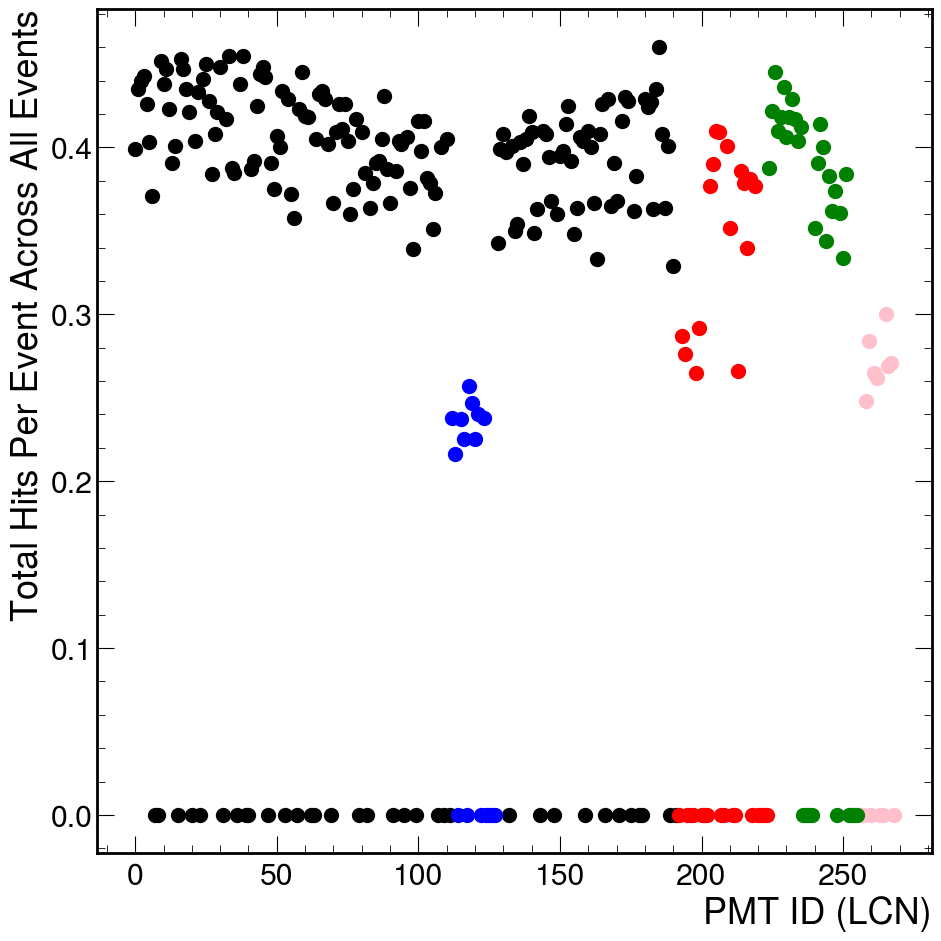

In [39]:
pmt_id_to_ch = dict(zip(run.pmt_id, run.pmt_ch))

# Assuming each PMT ID maps directly to its LCN (i.e., pmt_id == lcn)
pmt_hit_counts = np.zeros(np.max(run.pmt_ch)+1, dtype=int)

# Count hits for online PMTs
for event in run.events:
    if True:#-500<event.mcx<500 and -500<event.mcy<500 and -500<event.mcz<500:
        for pmt_id,time in zip(event.digit_pmt_id, event.digit_time_ns):
            if run.pmt_is_online[pmt_id] and -10<time<10:
                pmt_hit_counts[pmt_id_to_ch[pmt_id]] += 1

print(np.max(run.pmt_ch))

coinc_hit_counts = pmt_hit_counts / len(run.events)

# Plot
plt.figure(figsize=(10, 10))
#plt.scatter(range(len(pmt_hit_counts)), coinc_hit_counts, s=50, alpha=0.5, color='black')

# Optional: highlight barrel and dichroic
plt.scatter(barrel_channels, coinc_hit_counts[barrel_channels], s=100, alpha=1, color='black', label='Barrel Channels')
plt.scatter(dichroic_channels, coinc_hit_counts[dichroic_channels], s=100, alpha=1, color='blue', label='Dichroic Channels')
plt.scatter(behind_channels, coinc_hit_counts[behind_channels], s=100, alpha=1, color='pink', label='Bottom 10" PMTs')
plt.scatter(bottom_channels, coinc_hit_counts[bottom_channels], s=100, alpha=1, color='green', label='Bottom 8" PMTs')
plt.scatter(top_channels, coinc_hit_counts[top_channels], s=100, alpha=1, color='red', label='Top PMTs')

plt.xlabel("PMT ID (LCN)")
plt.ylabel("Total Hits Per Event Across All Events")
#plt.legend(loc='lower left')
#plt.ylim(np.max(pmt_hit_counts)/2,2*np.max(pmt_hit_counts))
plt.tight_layout()


Dichroic avg: 0.235 ± 0.005 hits/event
Bottom 8" avg: 0.394 ± 0.004 hits/event
Ratio (dichroic/bottom): 0.60 ± 0.01


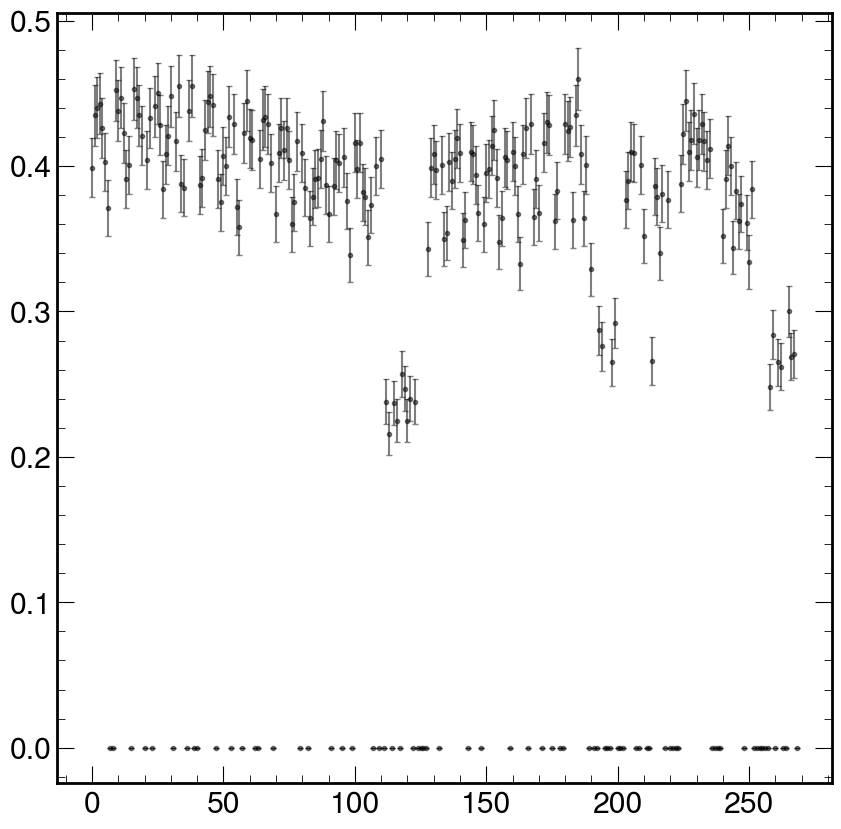

In [42]:
import numpy as np
from uncertainties import ufloat  # Requires `uncertainties` package (pip install uncertainties)

# Convert hit counts to rates and propagate Poisson errors
pmt_hit_rates = []
pmt_hit_errors = []

for count in pmt_hit_counts:
    # For each PMT: rate = count / N_events, with uncertainty √count / N_events
    N_events = len(run.events)
    rate = count / N_events
    error = np.sqrt(count) / N_events  # Poisson error propagation
    pmt_hit_rates.append(rate)
    pmt_hit_errors.append(error)

# Convert to numpy arrays
pmt_hit_rates = np.array(pmt_hit_rates)
pmt_hit_errors = np.array(pmt_hit_errors)

# Plot with error bars
plt.errorbar(
    x=np.arange(len(pmt_hit_rates)),
    y=pmt_hit_rates,
    yerr=pmt_hit_errors,
    fmt='o',
    markersize=3,
    capsize=2,
    alpha=0.5,
    color='black',
    label='PMT hit rates ± 1σ'
)

def weighted_average_with_uncertainty(rates, errors):
    """Calculate weighted average and its uncertainty."""
    weights = 1 / (errors ** 2)
    avg = np.sum(weights * rates) / np.sum(weights)
    err = 1 / np.sqrt(np.sum(weights))
    return avg, err

# Dichroic channels
dichroic_rates = pmt_hit_rates[dichroic_channels]
dichroic_errors = pmt_hit_errors[dichroic_channels]
avg_dichroic, err_dichroic = weighted_average_with_uncertainty(
    dichroic_rates[dichroic_rates > 0.01],
    dichroic_errors[dichroic_rates > 0.01]
)

# Bottom 8" channels
bottom_rates = pmt_hit_rates[bottom_channels]
bottom_errors = pmt_hit_errors[bottom_channels]
avg_bottom, err_bottom = weighted_average_with_uncertainty(
    bottom_rates[bottom_rates > 0.1],
    bottom_errors[bottom_rates > 0.1]
)

print(f"Dichroic avg: {avg_dichroic:.3f} ± {err_dichroic:.3f} hits/event")
print(f"Bottom 8\" avg: {avg_bottom:.3f} ± {err_bottom:.3f} hits/event")

R = avg_dichroic / avg_bottom
R_err = R * np.sqrt((err_dichroic/avg_dichroic)**2 + (err_bottom/avg_bottom)**2)

print(f"Ratio (dichroic/bottom): {R:.2f} ± {R_err:.2f}")